# Random basics - datasets / dataloaders & optimizers 

In this notebook I experiment with creating a custom dataset and transform as well as with creating some optimizers from scratch using pytorch. My personal highlight was to see that even a method like Covariance Matrix Adaption (an evolutionary strategy based algorithm) can be implemented using pytorch and actually performs reasonably well.

**Things to look at**

1. DONE opt: SGD, RMSProp, Adam, evo ([example](https://towardsdatascience.com/paper-repro-deep-neuroevolution-756871e00a66))
2. nets: dense, conv, recurrent, ResNet, DensNet
3. regularization: dropout, l2, weight decay, batchnorm
4. DONE data bunching (this kind of seems nasty) - data/application: image, tabular, sequence/text, collab
5. GANs, U-net, Feature loss

In [1]:
%matplotlib inline

In [2]:
from fastai.data_block import ItemList, ItemBase
from fastai import basic_data
from fastai.basic_data import DataBunch
from fastai.tabular import TabularList, Normalize, FillMissing
from fastai.basics import torch

In [3]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

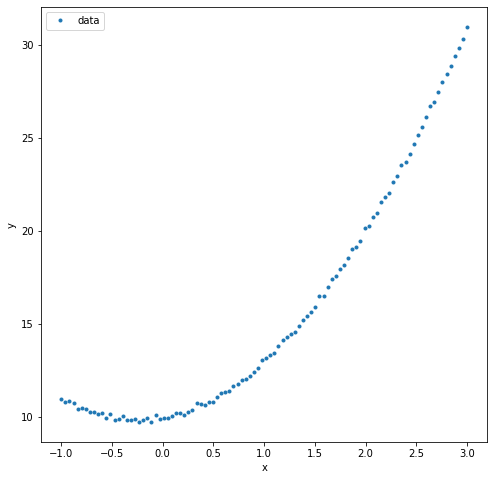

In [4]:
x = np.linspace(-1, 3, 100)
p = [2, 1,10]
y_err = stats.norm(loc=0, scale=.1).rvs(size=x.shape[0])
y_fun = lambda x: np.polyval(p, x) + y_err

y = y_fun(x)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(x, y, ".", label="data")
ax.set_xlabel("x")
ax.set_ylabel("y")
# ax.set_aspect("equal")
ax.legend()
plt.show()

In [5]:
print(x, y)

[-1.       -0.959596 -0.919192 -0.878788 ...  2.878788  2.919192  2.959596  3.      ] [10.988726 10.806739 10.889134 10.767511 ... 29.403792 29.84802  30.307792 30.987568]


## Custom data set and data loader

In [6]:
class XYDataset(torch.utils.data.Dataset):
    
    def __init__(self, x: np.ndarray, y: np.ndarray):
        assert len(x) == len(y)
        self.x = torch.from_numpy(x).clone()
        self.y = torch.from_numpy(y).clone()
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
def get_train_valid_idx(x, y, val_pct=.8):
    assert len(x) == len(y)
    ix = np.arange(len(x))
    
    train_idx = np.random.choice(ix, int(val_pct*len(x)), replace=False)
    valid_idx = np.setdiff1d(ix, train_idx)
    return train_idx, valid_idx


In [7]:
train_idx, valid_idx = get_train_valid_idx(x, y, val_pct=.8)
xy_train_ds = XYDataset(x[train_idx], y[train_idx])
xy_valid_ds = XYDataset(x[valid_idx], y[valid_idx])

In [8]:
xy_train_ds[2]

(tensor(2.6364, dtype=torch.float64), tensor(26.7277, dtype=torch.float64))

In [9]:
xy_valid_ds[4]

(tensor(0.0505, dtype=torch.float64), tensor(9.9704, dtype=torch.float64))

Creating a `DataBunch` version 1 via `torch.utils.data.DataLoader`

In [10]:
device = "cpu" # "cuda:0"

In [11]:
def noisify(xy):
    x, y = xy
    if not torch.is_tensor(x):
        x = torch.from_numpy(x).clone().to(device)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y).clone().to(device)
    
    dx = torch.normal(mean=0., std=.1, size=x.size()).to(device)
    dy = torch.normal(mean=0., std=.1, size=y.size()).to(device)
    return x + dx, y + dy

print(noisify((x[:5], y[:5])))

(tensor([-1.0289, -0.8809, -0.9947, -0.7316, -0.8059], dtype=torch.float64), tensor([10.8484, 10.8808, 10.7765, 10.7676, 10.3915], dtype=torch.float64))


In [ ]:
bs = 10

In [142]:
xy_train_loader = torch.utils.data.DataLoader(xy_train_ds, batch_size=bs, shuffle=True)
xy_valid_loader = torch.utils.data.DataLoader(xy_valid_ds, batch_size=bs, shuffle=True)
xy_db = basic_data.DataBunch(train_dl=xy_train_loader, valid_dl=xy_valid_loader) #, dl_tfms=noisify)

Creating a `DataBunch` version 2 via `basic_data.DataBunch.create`

In [ ]:
xy_db = basic_data.DataBunch.create(train_ds=xy_train_ds, valid_ds=xy_valid_ds, bs=bs)

In [122]:
n = len(x)
n_train = int(.7*n)
ix_train = np.random.choice(np.arange(n), replace=False, size=n_train)
ix_valid = np.setdiff1d(np.arange(n), ix_train)
print(ix_train.shape, ix_valid.shape)

df_train = pd.DataFrame({"x": x[ix_train], "y": y[ix_train]})
df_train["valid"] = False
df_valid = pd.DataFrame({"x": x[ix_valid], "y": y[ix_valid]})
df_valid["valid"] = True
df = pd.concat((df_train, df_valid), ignore_index=True)
df.head()

(70,) (30,)


,x,y,valid
0,1.343434,14.913624,False
1,0.898990,12.412504,False
2,2.717172,27.475066,False
3,-0.676768,10.253358,False
4,1.989899,20.181437,False


Note that if you use the following method the first component returned by `one_batch()` will be a list of two tensors, where the first seems, oddly enough, to have no real purpose. This won't cause an error for the model (`PolyModel`) because it is taken into account there.

In [139]:
def split_fun(x):
    return df["set"][x] == "valid"

def label_fun(x):
    print(x)
    return df["y"][x]

src = (TabularList.from_df(df=df, cont_names=["x"], procs=[Normalize])
      .split_from_df(col="valid")
      .label_from_df(cols="y"))

xy_db = src.databunch(bs=bs)

In [143]:
xy_db.one_batch() # cpu=False

(tensor([ 0.7374,  2.1515, -0.6768,  2.7172,  2.6364, -0.9596,  1.5859,  2.4747,
          0.4545, -1.0000], dtype=torch.float64),
 tensor([11.7516, 21.5481, 10.2534, 27.4751, 26.7277, 10.8067, 16.4968, 24.6748,
         10.7876, 10.9887], dtype=torch.float64))

## Setting up a polynomial model & loss

In [136]:
class PolyModel(torch.nn.Module):
    
    def __init__(self, deg: int = 1):
        super().__init__()
        self.deg = deg
        self.w = torch.nn.Parameter(torch.randn(deg))
        
    def forward(self, x):
        if isinstance(x, list):
            x = x[1]
        n = len(x)
        X = torch.empty(n, self.deg)
        #print("X", X)
        for i in range(self.deg):
            X[:,i] = x ** (self.deg-i-1)
        #print("\nX", X)
        return X @ self.w
        

In [15]:
def MSELoss(pred, truth):
    return ((pred-truth)**2).mean()

In [144]:
pm = PolyModel(deg=3)
pm(torch.randn(5))
pm.w

Parameter containing:
tensor([ 0.2001,  0.0199, -2.1910], requires_grad=True)

In [145]:
_y, _x = xy_db.one_batch()
_y_pred = pm(_x)
_y_pred

tensor([190.5820,  20.1090,  91.1555,  19.0513, 149.4184,  23.7011,  25.6788,
         18.2574,  22.1919,  18.4397], grad_fn=<MvBackward>)

## Optimization

**Implementing a bunch of optimizers**

Simple gradient based

In [160]:
class SGD:
    
    lr = .01
    name = "basic SGD"
    loss = None
    
    def __init__(self, lr=.01):
        self.lr = lr
    
    def update(self):
        _x, _y = xy_db.one_batch()
        _y_pred = pm(_x)
        loss = MSELoss(_y_pred, _y)
        loss.backward()

        with torch.no_grad():
            pm.w.sub_(pm.w.grad * self.lr)
            pm.w.grad.zero_()

        self.loss = loss.clone().detach().numpy()
        

With "momentum"

In [164]:
class SGD_mom:
    velo = torch.normal(mean=0, std=.001, size=pm.w.size()).to(device)
    momentum = .9
    lr = .01
    name = "SGD + momentum"
    loss = None
    
    def __init__(self, momentum=.9, lr=.01):
        self.momentum = momentum
        self.lr = lr

    def update(self):
        _x, _y = xy_db.one_batch()
        _y_pred = pm(_x)
        loss = MSELoss(_y_pred, _y)
        loss.backward()

        with torch.no_grad():
            self.velo.mul_(self.momentum)
            self.velo.add_(self.lr * pm.w.grad)

            pm.w.sub_(self.velo)
            pm.w.grad.zero_()

        self.loss = loss.clone().detach().numpy()
        

With "momentum" and "weight decay"

In [168]:
class SGD_mom_decay:
    velo = torch.normal(mean=0, std=.001, size=pm.w.size()).to(device)
    momentum = .9
    lr = .01
    wd = .1
    name = "SGD + momentum + weight decay"
    loss = None
    
    def __init__(self, momentum=.9, lr=.01, wd=.1):
        self.momentum = momentum
        self.lr = lr
        self.wd = wd

    def update(self):
        _x, _y = xy_db.one_batch()
        _y_pred = pm(_x)
        loss = MSELoss(_y_pred, _y)
        loss.backward()

        with torch.no_grad():
            self.velo.mul_(self.momentum)
            self.velo.add_(self.lr * pm.w.grad)

            pm.w.sub_(self.velo + self.wd*pm.w)
            pm.w.grad.zero_()

        self.loss = loss.clone().detach().numpy()
        

RMSProp: [coursera course](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf), [paper](http://arxiv.org/abs/1308.0850), a [blog post](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a)

In [177]:
class RMSProp:
    velo = torch.normal(mean=0, std=.01, size=pm.w.size()).to(device)
    momentum = .9
    wd = .1
    beta = .9
    lr = .01
    mag = torch.tensor(1.).to(device)
    name = "RMSProp"
    
    def __init__(self, momentum=.9, lr=.01, wd=.1, beta=.9):
        self.momentum = momentum
        self.lr = lr
        self.wd = wd
        self.beta = beta
    
    def update(self):
        _x, _y = xy_db.one_batch()
        _y_pred = pm(_x)
        loss = MSELoss(_y_pred, _y)
        loss.backward()

        with torch.no_grad():
            self.mag.mul_(self.beta)
            self.mag.add_((1.-self.beta) * (pm.w @ pm.w))

            self.velo.mul_(self.momentum)
            self.velo.add_(self.lr/torch.sqrt(self.mag) * pm.w.grad)

            pm.w.sub_(self.velo + self.wd*pm.w)
            pm.w.grad.zero_()
        
        self.loss = loss.clone().detach().numpy()
        

Adam: [arXiv](https://arxiv.org/abs/1412.6980)

In [184]:
class Adam:
    
    moment1 = torch.zeros_like(pm.w, requires_grad=False)
    moment2 = torch.zeros_like(pm.w, requires_grad=False)
    betas = torch.tensor([.9, .999], requires_grad=False)
    eps = torch.tensor(1e-8, requires_grad=False)
    lr = .01
    name = "Adam"
    loss = None
    
    def __init__(self, lr: float = .01, betas: list = [.9, .999], eps: float =1e-8):
        self.betas = torch.tensor(betas, requires_grad=False)
        self.eps = eps
        self.lr = lr
    
    def update(self):
        _x, _y = xy_db.one_batch()
        _y_pred = pm(_x)
        loss = MSELoss(_y_pred, _y)
        loss.backward()

        with torch.no_grad():

            self.moment1.mul_(self.betas[0])
            self.moment1.add_((1.-self.betas[0]) * pm.w.grad)
            moment1_hat = self.moment1.div(1.-self.betas[0]**(epoch+1))

            self.moment2.mul_(self.betas[1])
            self.moment2.add_((1.-self.betas[1]) * (pm.w.grad * pm.w.grad))
            moment2_hat = self.moment2.div(1.-self.betas[1]**(epoch+1))

            pm.w.sub_(self.lr * moment1_hat / (torch.sqrt(moment2_hat) + self.eps))

        self.loss = loss.clone().detach().numpy()
    

In [273]:
moment1 = torch.zeros_like(pm.w, requires_grad=False)
# moment2 = torch.zeros(1, requires_grad=False)
moment2 = torch.zeros_like(pm.w, requires_grad=False)
betas = torch.tensor([.9, .999], requires_grad=False)
eps = torch.tensor(1e-8, requires_grad=False)

In [274]:
print(moment1, moment2, betas)

tensor([0., 0., 0.]) tensor([0., 0., 0.]) tensor([0.9000, 0.9990])


In [275]:
def update():
    _x, _y = xy_db.one_batch()
    _y_pred = pm(_x)
    loss = MSELoss(_y_pred, _y)
    loss.backward()

    with torch.no_grad():
        
        moment1.mul_(betas[0])
        moment1.add_((1.-betas[0]) * pm.w.grad)
        moment1_hat = moment1.div(1.-betas[0]**(epoch+1))
        
        moment2.mul_(betas[1])
        moment2.add_((1.-betas[1]) * (pm.w.grad * pm.w.grad))
        moment2_hat = moment2.div(1.-betas[1]**(epoch+1))
        
        pm.w.sub_(lr * moment1_hat / (torch.sqrt(moment2_hat) + eps))
    
    losses.append(loss.clone().detach().numpy())
    update_method.append("Adam")

Covariance Matrix Adaption Evolution Strategy (CMA-ES): [tutorial](https://arxiv.org/abs/1604.00772), [wiki](https://en.wikipedia.org/wiki/CMA-ES)
You may also want to check out [this](https://eli.thegreenplace.net/2011/05/15/understanding-unboundlocalerror-in-python) for variable scoping.

In [218]:
class CMA_ES:
    
    _lambda = 9 # number of agents
    mu = 4 # number of children which survive the culling
    N = pm.w.size()[0] # number of parameters

    m = pm.w.clone().detach() # position of the normal distribution
    sigma = .3 # coordinate wise standard deviation (step size)
    weights = None   # recombination weights
    mueff = None

    # Strategy parameter setting: Adaptation
    cc = None # time constant for cumulation for C
    cs = None # t-const for cumulation for sigma control
    c1 = None # learning rate for rank-one update of C
    cmu = None
    damps = None # damping for sigma, usually close to 1
    
    # Initialize dynamic (internal) strategy parameters and constants
    pc = torch.zeros(1, N).detach() # evolution paths for C and sigma
    ps = torch.zeros(1, N).detach() # evolution paths for C and sigma
    

    C = torch.eye(n=N, dtype=torch.float).detach()
    B = torch.eye(N, N).detach() # B defines the coordinate system
    D = torch.ones(N).detach() # diagonal D defines the scaling
    invsqrtC = B @ torch.diag(1 / D) @ B.transpose(0, 1)
    
    eigeneval = 0 # track update of B and D
    chiN = N**.5 * (1. - 1./(4.*N) + 1./(21.*N**2))
    
    name = "CMA-ES"
    
    def __init__(self, _lambda: int = 9, mu: int = 4, sigma: float = .3):
        self._lambda = _lambda
        self.mu = mu
        self.sigma = sigma
        
        with torch.no_grad():
            #self.agents = torch.ones((_lambda, self.N)).detach()
            self.weights = torch.ones(mu).detach()/float(mu)
            self.mueff = self.weights.sum()**2 / (self.weights @ self.weights).sum()

            self.cc = (4. + self.mueff / self.N) / (self.N + 4 + 2 * self.mueff / self.N) # time constant for cumulation for C
            self.cs = (self.mueff + 2) / (self.N + self.mueff + 5) # t-const for cumulation for sigma control
            self.c1 = 2 / ((self.N+1.3)**2 + self.mueff) # learning rate for rank-one update of C
            self.cmu = min([1 - self.c1, 2 * (self.mueff - 2 + 1 / self.mueff) / ((self.N + 2)**2 + self.mueff)])
            self.damps = 1 + 2 * max(0, torch.sqrt((self.mueff - 1)/(self.N + 1)) - 1) + self.cs # damping for sigma, usually close to 1

    def update(self):

        _x, _y = xy_db.one_batch()
        _y_pred = pm(_x)
        loss = MSELoss(_y_pred, _y)

        with torch.no_grad():


            agents = (torch.distributions.multivariate_normal.MultivariateNormal(self.m, covariance_matrix = self.C)
                      .sample(sample_shape=torch.Size([self._lambda])))

            for _i in range(self._lambda):
                pm.w = torch.nn.Parameter(agents[_i])
                _y_pred = pm(_x)
                fitnesses[_i] = MSELoss(_y_pred, _y)

            idx = torch.argsort(fitnesses)[:self.mu] # assumes that the best individuals are those with the lowest fitness values

            m_new = agents[idx].mean(dim=0)

            # Update evolution paths     
            self.ps = (1-self.cs) * self.ps + torch.sqrt(self.cs * (2-self.cs)*self.mueff) \
                      * self.invsqrtC @ (m_new - self.m)/self.sigma

            hsig = 2./(self.N+1.)
            if not (torch.norm(self.ps) / torch.sqrt(1-(1-self.cs)**(2*(epoch+1)/self._lambda))/self.chiN < 1.4):
                hsig += 1.

            self.pc = (1-self.cc) * self.pc + hsig * torch.sqrt(self.cc * (2-self.cc)*self.mueff) \
                      * (m_new - self.m)/self.sigma

            # Adapt covariance matrix C
            artmp = 1/self.sigma * (agents[idx] - self.m)

            self.C = (1. - self.c1 - self.cmu) * self.C \
                      + self.c1 * ( \
                              torch.einsum("i,j->ij", self.pc[0], self.pc[0]) \
                              + (1-hsig) * self.cc*(2-self.cc) * self.C
                             ) \
                      + self.cmu * artmp.transpose(0, 1) @ torch.diag(self.weights) @ artmp

            self.sigma = self.sigma * torch.exp((self.cs/self.damps)*(torch.norm(self.ps)/self.chiN - 1.))

            if epoch - self.eigeneval > self._lambda/(self.c1+self.cmu)/self.N/10.:

                self.eigeneval = epoch
                self.C = self.C.triu() + self.C.triu(1).transpose(0, 1)
                (D, B) = self.C.eig(eigenvectors=True)
                self.invsqrtC = B @ torch.diag(1./D[:,0]) @ B.transpose(0, 1)

            pm.w = torch.nn.Parameter(m_new)
            self.m = m_new.clone()
            
            
        
        self.loss = loss.clone().detach().numpy()


With one of pytorch's optimizers

In [289]:
# opt = torch.optim.SGD(pm.parameters(), lr=.01, momentum=.9)

class PyTorch:
    
    opt = None
    _opt = None
    opt_args = None
    opt_kwargs = None
    loss = None
    name = "pytorch optimizer"
    
    def __init__(self, opt: torch.optim.Optimizer, *opt_args, **opt_kwargs):
        self.opt = opt
        self.opt_args = opt_args
        self.opt_kwargs = opt_kwargs
        
    def update(self):
        
        if epoch == 0:
            self._opt = self.opt(params=[pm.w], *self.opt_args, **self.opt_kwargs)
            
        self._opt.zero_grad()
        _x, _y = xy_db.one_batch()
        _y_pred = pm(_x)
        loss = MSELoss(_y_pred, _y)
        loss.backward()

        self._opt.step()

        self.loss = loss.clone().detach().numpy()


**Running an optimizer for a while**

In [299]:
# initialize random weights
pm = PolyModel(deg=3)
pm(torch.randn(5))

tensor([-0.7054, -0.2124, -0.4480, -0.1544, -0.8015], grad_fn=<MvBackward>)

In [300]:
n_epochs = 50

In [298]:
losses = []
update_method = []

In [293]:
pm.w

Parameter containing:
tensor([0.2177, 0.9247, 0.5363], requires_grad=True)

In [294]:
# _optimizer = SGD(lr=.01)
# _optimizer = SGD_mom(lr=.01, momentum=.9)
# _optimizer = SGD_mom_decay(lr=.01, momentum=.9, wd=.1)
# _optimizer = RMSProp(lr=.01, momentum=.9, wd=.1, beta=.9)
# _optimizer = Adam(lr=.01, betas=[.9, .999], eps=1e-8)
# _optimizer = CMA_ES(_lambda=9, mu=4, sigma=.3)
_optimizer = PyTorch(opt=torch.optim.SGD, lr=.01, momentum=.9)

for epoch in range(n_epochs): # range(n_epochs):
    #update()
    _optimizer.update()
    update_method.append(_optimizer.name)
    losses.append(_optimizer.loss)

In [295]:
pm.w

Parameter containing:
tensor([ 2.0420,  1.1468, 10.3455], requires_grad=True)

**Running a bunch of different optimizers**

Essentially the same as above but directly running a series of optimizers.

In [301]:
w0 = pm.w.clone()

In [302]:
optimizers = [
    SGD(lr=.01),
    SGD_mom(lr=.01, momentum=.9),
    SGD_mom_decay(lr=.01, momentum=.9, wd=.1),
    RMSProp(lr=.01, momentum=.9, wd=.1, beta=.9),
    Adam(lr=.01, betas=[.9, .999], eps=1e-8),
    CMA_ES(_lambda=9, mu=4, sigma=.3),
    PyTorch(opt=torch.optim.SGD, lr=.01, momentum=.9),
]

for _optimizer in optimizers:
    print("\n", _optimizer)
    pm.w = torch.nn.Parameter(w0.clone())
    for epoch in range(n_epochs):
        _optimizer.update()
        update_method.append(_optimizer.name)
        losses.append(_optimizer.loss)
    print(pm.w)


Parameter containing:
tensor([3.0441, 1.2554, 4.2178], requires_grad=True)

Parameter containing:
tensor([ 1.6727,  0.7243, 10.2558], requires_grad=True)

Parameter containing:
tensor([2.6580, 1.0982, 5.4977], requires_grad=True)

Parameter containing:
tensor([2.8512, 1.2903, 2.4884], requires_grad=True)

Parameter containing:
tensor([ 0.3541, -0.2096, -0.5111], requires_grad=True)

Parameter containing:
tensor([0.4132, 7.7309, 3.5119], requires_grad=True)

Parameter containing:
tensor([ 1.8327,  1.1074, 10.7989], requires_grad=True)


**How well is the data fitted for a single weights vector?**

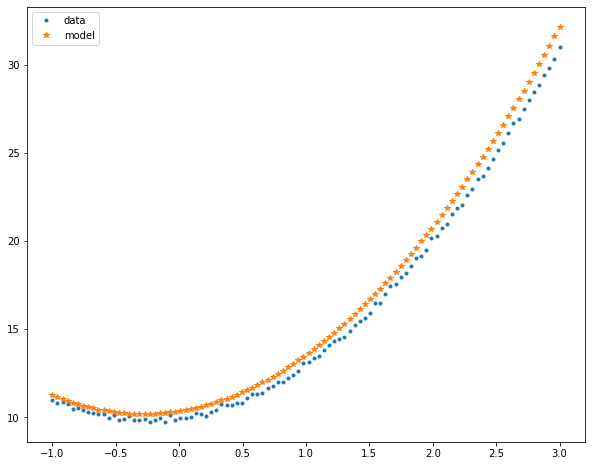

In [296]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x, y, ".", label="data")
with torch.no_grad():
    ax.plot(x, pm(torch.from_numpy(x).clone()), "*", label="model")
ax.legend()
plt.show()

**Loss plots over multiple optimization methods**

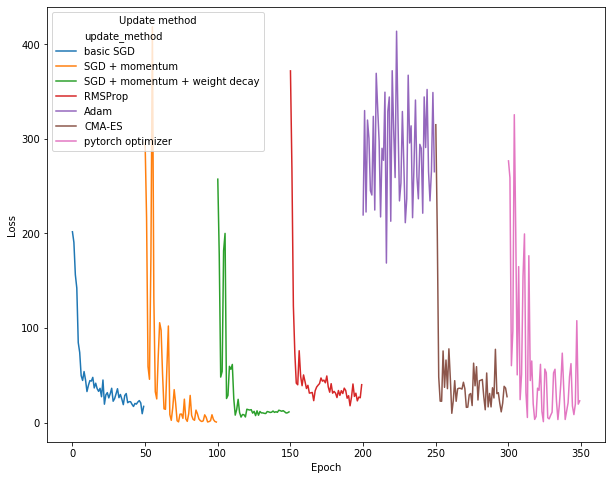

In [303]:
df_plot = pd.DataFrame({"update_method": update_method, "losses": np.array(losses), "epoch": np.arange(len(losses))})

fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=df_plot, x="epoch", y="losses", ax=ax , hue="update_method")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(title="Update method")
plt.show()